# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import pandas as pd
import scipy.signal as signal
import random 
import pywt
from sklearn.cross_decomposition import CCA

# Set Up

In [3]:
# Filtering

low_freq = 5
high_freq = 40
sampling_rate = 250

b, a = signal.butter(4, [low_freq, high_freq], fs=sampling_rate, btype='band')

In [4]:
# Loading up general data

sampling_rate = 250
data_frequencies, electrodes_names = utils.load_ssvep_additional_info("../TFM-GitHub/Dataset BETA/S1")
occipital_electrodes, occipital_electrodes_indexes, occipital_electrodes_names = utils.select_occipital_electrodes(electrodes_names)

samples_without_stimulus = int(0.5 * sampling_rate)

# Continuous Wavelet Transform analysis functions and example

Here we are simply loading the data for subject 18's first trial under an 11 Hz stimulus. We apply the filtering step and then plot the corresponding wavelet transform.

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_73938/2747609543.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


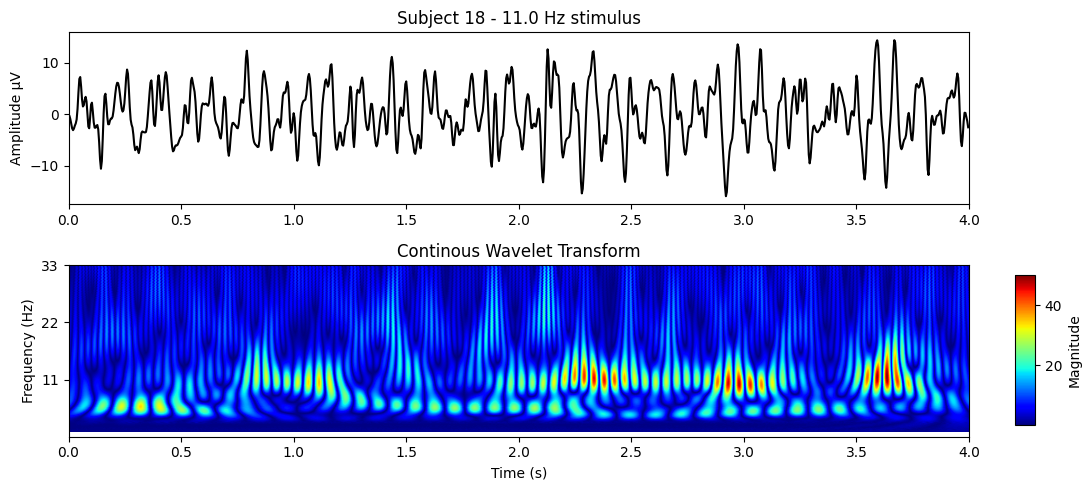

In [5]:
subject = 18
freq_index = 12

eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)
t = np.arange(0, 1000/sampling_rate, 1/sampling_rate)

sampling_rate = 250

filtered_data = signal.lfilter(b, a, eeg_data[61, :, 0, freq_index])

frequencies = np.arange(1, 40, 0.01) /sampling_rate 
wavelet_name = "morl"
# Pasamos de frecuencias a escalas para utilizarlas en la transformada
scales = pywt.frequency2scale(wavelet_name, frequencies) 
# Transformada Wavelet
cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name) 
# Multiplicamos por samping_rate para recuperar las frecuencias en Hz
frequencies = frequencies*sampling_rate 

f_idx = freq_index
f_value = data_frequencies[f_idx]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 5))

ax1.plot(t,filtered_data, 'k')
ax1.set_xlim(0, 4)
ax1.set_ylabel("Amplitude " + '\u03BC' + "V")
ax1.set_title("Subject " + str(subject) + " - " + str(data_frequencies[freq_index]) +" Hz stimulus")

ax2.imshow(np.abs(cwtmatr), aspect='auto', cmap='jet', extent=[0, len(t) / sampling_rate, frequencies[-1], frequencies[0]], origin='upper')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title("Continous Wavelet Transform")
ax2.set_ylim(0, 30)
ax2.set_yticks([11, 22, 33])
cbar_ax2 = fig.add_axes([1.02, 0.14 , 0.02, 0.3])
plt.colorbar(ax2.images[0], cax=cbar_ax2, label="Magnitude")


plt.tight_layout()

Now, what we will do is create some functions that recieve an EEG recording and the frequency of interest. These functions will obtain the wavelet transfrom and obtain some info about the selected frequency.

Information they will return:
- Plot of frequency magnutde distribution
- Plot of magnitude over time for that frequency
- Maximum magnitude within that frequency
- Average duration of periods where the magnitude was lower than 20
- Number of periods where magnitude was lower than 20
- Average magntidue of periods under 20 and above 20

We also have some functions to characterize the wavelet transform subgroups.

What they will let us know:
- Plot of frequency magnitude distribution above 20
- For the frequency of interest number of samples on top and bellow the frequency above 40 in magnitude (height) over time
- Average considering only values above 0 (only the actual groups above 40)
- Centering of said groups (which frequency has the highest magnitude)

In [104]:
def wavelet_transform(eeg_data, sampling_rate):
    frequencies = np.arange(1, 40, 0.01)/sampling_rate 
    wavelet_name = "morl"
    # Pasamos de frecuencias a escalas para utilizarlas en la transformada
    scales = pywt.frequency2scale(wavelet_name, frequencies) 
    # Transformada Wavelet
    cwtmatr, freqs = pywt.cwt(eeg_data, scales, wavelet_name) 
    # Multiplicamos por samping_rate para recuperar las frecuencias en Hz
    frequencies = frequencies*sampling_rate 

    return cwtmatr


def magnitude_over_time(cwtmatr, frequency, path):

    freq_index = int(frequency / 0.01 - (1 /0.01))

    plt.plot(cwtmatr[freq_index])
    plt.title("CWT magnitude over time")

    if path != "":
        final_path = "../../Universidad/TFM/Imágenes/Results/Statistics/"+path

        plt.savefig(final_path, dpi='figure', format=None)

    else:
        plt.show()


def magnitude_distribution(cwtmatr, frequency, path, threshold = 0):

    freq_index = int(frequency / 0.01 - (1 /0.01))

    plt.hist(cwtmatr[freq_index][cwtmatr[freq_index] > threshold])
    plt.xlim(0, 50)
    plt.ylabel("Nº samples")
    plt.xlabel("Magnitude")
    plt.title("Magnitude distribution")

    if path != "":
        final_path = "../../Universidad/TFM/Imágenes/Results/Statistics/"+path

        plt.savefig(final_path, dpi='figure', format=None)
    else:
        plt.show()

def max_magnitude(cwtmatr, frequency):

    freq_index = int(frequency / 0.01 - (1 /0.01))

    return max(cwtmatr[freq_index])

def average_magnitude(cwtmatr, frequency, threshold):

    freq_index = int(frequency / 0.01 - (1 /0.01))

    return np.mean(cwtmatr[freq_index][cwtmatr[freq_index] > threshold])

def attention_loss_info(cwtmatr, frequency, sampling_rate):

    periods = []
    freq_index = int(frequency / 0.01 - (1 /0.01))

    ini = -1
    end = -1

    duration = 0

    av_magn_periods = 0
    av_magn_ok = 0
    total_periods = 0
    total_ok = 0

    aux = 0
    aux_total = 0

    for i in range(int(0.5 *250), cwtmatr.shape[1] - (int(0.5*250))):

        
        if cwtmatr[freq_index][i] < 10:

            # If ini was -1 then we are starting a new period
            if ini == -1:

                if aux_total != 0: av_magn_periods += aux/aux_total

                total_periods += 1
                aux_total = 0
                aux = 0
                ini = i
                end = i

                if cwtmatr[freq_index][i] > 0:
                    aux_total += 1
                    aux += cwtmatr[freq_index][i]

            # Otherwise we need to update the end of the current period
            else:
                end = i
                if cwtmatr[freq_index][i] > 0:
                    aux_total += 1
                    aux += cwtmatr[freq_index][i]

        else:

            aux_total += 1
            aux += cwtmatr[freq_index][i]
            
            # If ini is not -1 then we are coming from a period where the attention was lost so we need to store it
            # We only store periods bigger than 0.1 because otherwise we would store false periods that happen between two peaks.
            if ini != -1 and end/sampling_rate - ini/sampling_rate > 0.1:
                if aux_total != 0: av_magn_periods += aux/aux_total
                aux_total = 0
                aux = 0
                total_ok += 1
                periods.append([ini/sampling_rate, end/sampling_rate])
                duration += (end/sampling_rate - ini/sampling_rate)

            ini = -1

    end = cwtmatr.shape[1]

    if ini != -1 and end/sampling_rate - ini/sampling_rate > 0.1:
        periods.append([ini/sampling_rate, end/sampling_rate])
        duration += (end/sampling_rate - ini/sampling_rate)
        total_periods += 1
    else:
        total_ok += 1
        
    
    if len(periods) != 0 and total_ok != 0 and total_periods != 0:
        return len(periods), duration/len(periods), av_magn_periods/total_periods, av_magn_ok/total_ok, periods

    else:
        return 0, 0, 0, 0, periods
    
def highest_magntiudes(cwtmatr, frequency, path):
    
    # Filter out magnitudes below 20
    cwtmatr_filtered = np.where(cwtmatr < 25, 0, cwtmatr)

    # Find the index of the maximum magnitude along the frequency axis for each time step
    max_freq_indices = np.argmax(cwtmatr_filtered, axis=0)

    # Extract the corresponding frequencies for each time step
    frequencies = np.arange(1, 40, step=0.01)
    max_freq_values = frequencies[max_freq_indices]

    t = np.arange(0, cwtmatr.shape[1]/250, 1/250)

    # Plot the time vs. the frequency with the highest magnitude
    plt.plot(t, max_freq_values, label='Frequency with Highest Magnitude (>25)')
    plt.axhline(frequency, color="red", label="Stimulus frequency")
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Highest magnitudes over time')
    plt.legend()
    plt.yticks(np.arange(1, 30, step=2))
    if cwtmatr.shape[1] > 800:
        plt.xlim(0, 4)
    else:
        plt.xlim(0, 3)

    if path != "":
        final_path = "../../Universidad/TFM/Imágenes/Results/Statistics/"+path
        plt.savefig(final_path, dpi='figure', format=None)
        
    else:    
        plt.show()



def average_thickness(cwtmatr, frequency):

    freq_index = int(frequency / 0.01 - (1 /0.01))

    total = 0
    count = 0

    for i in range(cwtmatr.shape[1]):
        if cwtmatr[freq_index][i] > 25:
            count += 1
            magnitude = cwtmatr[freq_index][i]
            j = freq_index
            while (magnitude > 25 and j < cwtmatr.shape[0]):
                magnitude = cwtmatr[j][i]
                if magnitude > 25:
                    total += 1
                j+=1
            j = freq_index
            while (magnitude > 25 and j > 0):
                magnitude = cwtmatr[j][i]
                if magnitude > 25:
                    total += 1
                j-=1

    if count != 0:
        return total/count
    else: 
        return 0



Maximum magnitude =  48.102426568677906
Average magnitude above 0 =  14.741999068467043
Average magnitude above 20 =  29.4462031422504
Average magnitude above 40 =  43.624003708892666

Average duration of periods of attention loss =  0.519
Number of periods where attention was lost =  4
Average magnitude of periods with attention loss =  -66.62548800991668
Average magnitude otherwise =  58.040038463395945
These are the periods of time where attention was lost =  [[0.0, 0.772], [1.168, 1.948], [3.176, 3.484], [3.784, 4.0]]
Here we plot lines marking the attention loss periods


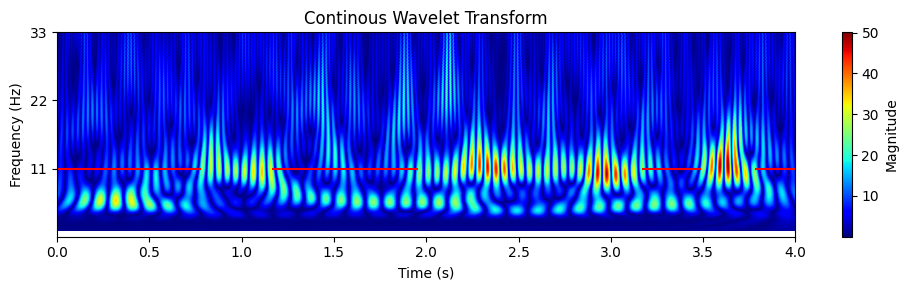

Average thickness of groups above 25 in samples =  159.85436893203882
Average thickness in Hz =  1.5985436893203884
Maximum magnitudes at each time point


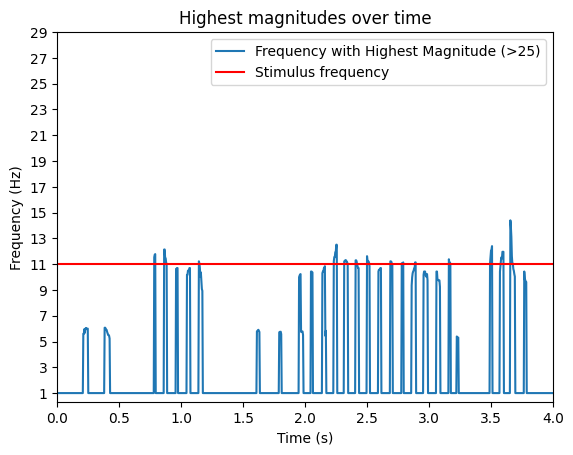

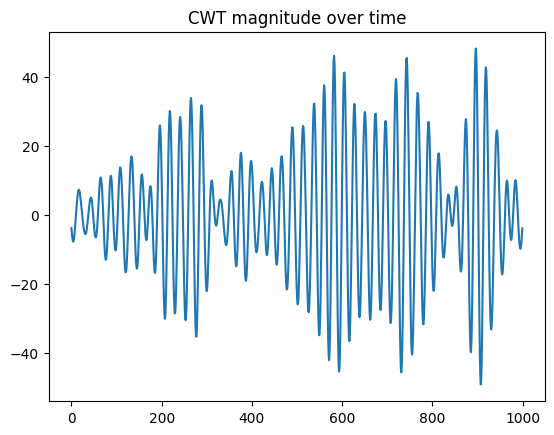

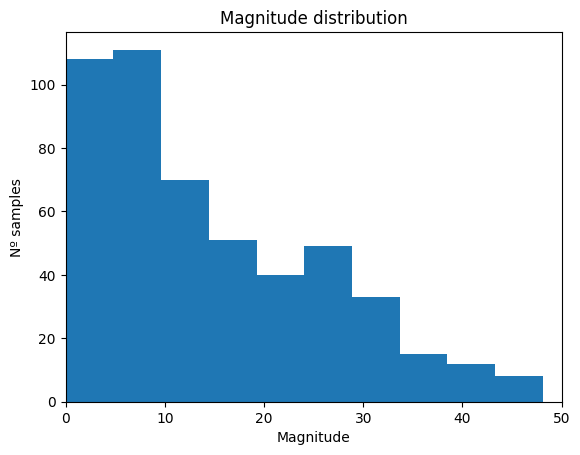

In [7]:
cwtmatr = wavelet_transform(filtered_data, sampling_rate)

print("Maximum magnitude = ", max_magnitude(cwtmatr, 11))
print("Average magnitude above 0 = ", average_magnitude(cwtmatr, 11, 0))
print("Average magnitude above 20 = ", average_magnitude(cwtmatr, 11, 20))
print("Average magnitude above 40 = ", average_magnitude(cwtmatr, 11, 40))

print()

n_periods, av_duration, av_below, av_above, periods = attention_loss_info(cwtmatr, 11, sampling_rate)

print("Average duration of periods of attention loss = ", av_duration)
print("Number of periods where attention was lost = ", n_periods)
print("Average magnitude of periods with attention loss = ", av_below)
print("Average magnitude otherwise = ", av_above)
print("These are the periods of time where attention was lost = ", periods)
print("Here we plot lines marking the attention loss periods")

t = np.arange(0, 1000/sampling_rate, 1/sampling_rate)

fig = plt.figure(figsize=(10, 3))
plt.imshow(np.abs(cwtmatr), aspect='auto', cmap='jet', extent=[0, len(t) / sampling_rate, frequencies[-1], frequencies[0]], origin='upper')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title("Continous Wavelet Transform")
plt.ylim(0, 30)
plt.yticks([11, 22, 33])
cbar_ax2 = plt.colorbar(label="Magnitude")
for period in periods:
    plt.axhline(11, period[0]/4, period[1]/4, color="red")


plt.tight_layout()
plt.show()



print("Average thickness of groups above 25 in samples = ", average_thickness(cwtmatr, 11))
print("Average thickness in Hz = ", average_thickness(cwtmatr, 11)*0.01)
print("Maximum magnitudes at each time point")
highest_magntiudes(cwtmatr, 11, "")

print()


print()


magnitude_over_time(cwtmatr, 11, "")
magnitude_distribution(cwtmatr, 11, "", 0)


# Individual results

In [328]:
sampling_rate = 250
path = "../TFM-GitHub/Dataset BETA/S" + str(subject) +".mat"
data_frequencies, electrodes_names = utils.load_ssvep_additional_info(path)
occipital_electrodes, occipital_electrodes_indexes, occipital_electrodes_names = utils.select_occipital_electrodes(electrodes_names)

samples_without_stimulus = int(0.5 * sampling_rate)

eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",18)


frequencies = [[11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6],
               [11, 13], [8.6, 15.6]]


subjects = [18, 18, 64, 64, 11, 11, 67, 67]
cases = ["best", "worst", "best", "worst", "paper_worst_best", "paper_worst_worst", "paper_best_best", "paper_best_worst"]

data_frequencies[-5] = 15.6

electrode_idx = 61
electrode_name = "OZ"

for i in range(len(subjects)):
    subject = subjects[i]
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)
    case = cases[i]
    for j in range(2):
        index = j+1
        fr_idx = 0
        freq = frequencies[i][j]
        for x in range(40):
            if data_frequencies[x] == freq:
                fr_idx = x
                break  

        for tr_idx in range(4):

            filtered_data = signal.lfilter(b, a, eeg_data[electrode_idx, :, tr_idx, fr_idx])

            freqs = np.arange(1, 40, 0.01) /sampling_rate 
            wavelet_name = "morl"
            # Pasamos de frecuencias a escalas para utilizarlas en la transformada
            scales = pywt.frequency2scale(wavelet_name, freqs) 
            # Transformada Wavelet
            cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name)

            n_periods, av_duration, av_below, av_above, periods = attention_loss_info(cwtmatr, freq, sampling_rate) 
            
            print("--------------------")
            print("Subject ", subject, " ", case, " case ", tr_idx, " trial")
            print("--------------------")

            print("Maximum magnitude of the frequency = ", max_magnitude(cwtmatr, freq))
            print("Average magnitude (only magnitudes above 20 = ", average_magnitude(cwtmatr, freq, 20))
            print("Average magniutde (only above 40)", average_magnitude(cwtmatr, freq, 40))
            print("Average duration of lost periods = ", av_duration)
            print("Number of lost periods = ", n_periods)
            print("Average magnitude of blank periods = ", av_below)
            print("Average magnitude non-blank periods = ", av_above)
            print("Average thichkness of non-blank periods = ", average_thickness(cwtmatr, freq))
            print("Average thichkness of non-blank periods (Hz) = ", average_thickness(cwtmatr, freq)*0.01)

            print()



--------------------
Subject  18   best  case  0  trial
--------------------
Maximum magnitude of the frequency =  48.102426568677906
Average magnitude (only magnitudes above 20 =  29.4462031422504
Average magniutde (only above 40) 43.624003708892666
Average duration of lost periods =  0.519
Number of lost periods =  4
Average magnitude of blank periods =  -66.62548800991668
Average magnitude non-blank periods =  58.040038463395945
Average thichkness of non-blank periods =  159.85436893203882
Average thichkness of non-blank periods (Hz) =  1.5985436893203884

--------------------
Subject  18   best  case  1  trial
--------------------
Maximum magnitude of the frequency =  42.664113421062765
Average magnitude (only magnitudes above 20 =  29.00112787567554
Average magniutde (only above 40) 41.69549244898083
Average duration of lost periods =  0.3128
Number of lost periods =  5
Average magnitude of blank periods =  -44.07782586548846
Average magnitude non-blank periods =  49.7404919389726

/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--------------------
Subject  18   worst  case  0  trial
--------------------
Maximum magnitude of the frequency =  41.022258704371254
Average magnitude (only magnitudes above 20 =  26.19510895965794
Average magniutde (only above 40) 41.022258704371254
Average duration of lost periods =  0.2773333333333333
Number of lost periods =  9
Average magnitude of blank periods =  -66.77028515633525
Average magnitude non-blank periods =  59.20010073929315
Average thichkness of non-blank periods =  138.76923076923077
Average thichkness of non-blank periods (Hz) =  1.3876923076923078

--------------------
Subject  18   worst  case  1  trial
--------------------
Maximum magnitude of the frequency =  41.542961140564714
Average magnitude (only magnitudes above 20 =  25.99589619511217
Average magniutde (only above 40) 41.542961140564714
Average duration of lost periods =  0.21839999999999998
Number of lost periods =  10
Average magnitude of blank periods =  -35.252510127282704
Average magnitude non-bl

In [357]:
def gen_table(subject, frequency):

    table = np.zeros((4, 9))

    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)

    fr_idx = 0
    freq = frequency
    for x in range(40):
        if data_frequencies[x] == freq:
            fr_idx = x
            break  

    data = []  
    for tr_index in range(0, 4):
        
        filtered_data = signal.lfilter(b, a, eeg_data[61, :, tr_index, fr_idx])

        freqs = np.arange(1, 40, 0.01) /sampling_rate 
        wavelet_name = "morl"
        # Pasamos de frecuencias a escalas para utilizarlas en la transformada
        scales = pywt.frequency2scale(wavelet_name, freqs) 
        # Transformada Wavelet
        cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name)

        n_periods, av_duration, av_below, av_above, periods = attention_loss_info(cwtmatr, freq, sampling_rate) 
        
        table[tr_index, 0] = max_magnitude(cwtmatr, freq)
        table[tr_index, 1] = average_magnitude(cwtmatr, freq, 20)
        table[tr_index, 2] = average_magnitude(cwtmatr, freq, 40)
        table[tr_index, 3] = av_duration
        table[tr_index, 4] = n_periods
        table[tr_index, 5] = av_below
        table[tr_index, 6] = av_above
        table[tr_index, 7] = average_thickness(cwtmatr, freq)
        table[tr_index, 8] = average_thickness(cwtmatr, freq) * 0.01

        data.append(filtered_data)

        path = "S" + str(subject) + "_F" + str(frequency) + "_T" + str(tr_index) +"_Highest_magnitudes.png"
        highest_magntiudes(cwtmatr, freq, path)
        plt.close()
        #path = "S" + str(subject) + "_F" + str(frequency) + "_T" + str(tr_index) + "_Magnitudes_over_time.png"
        #magnitude_over_time(cwtmatr, freq, path)
        #plt.close()
        path = "S" + str(subject) + "_F" + str(frequency) + "_T" + str(tr_index) + "_Magnitude_distribution.png"
        magnitude_distribution(cwtmatr, freq, path, 0)
        plt.close()


    df = pd.DataFrame(table, index=["T1", "T2", "T3", "T4"], columns=["Max magn", "Avg magn >20", "Avg magn >40", "Avg blank", "N blanks", "Avg magn blank", "Avg magn non", "Avg thick", "Avg thick (Hz)"])
    display(df)

**Subject 18**

In [358]:
print("Subject 18: ")
print()

print(" - Best case scenario 11 Hz")
gen_table(18, 11)

print(" - Best case scenario 13 Hz")
gen_table(18, 13)

print(" - Worst case scenario 8.6 Hz")
gen_table(18, 8.6)

print(" - Worst case scenario 15.6 Hz")
gen_table(18, 15.6)

Subject 18: 

 - Best case scenario 11 Hz


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,48.102427,29.446203,43.624004,0.5190,4.0,-66.625488,58.040038,159.854369,1.598544
T2,42.664113,29.001128,41.695492,0.3128,5.0,-44.077826,49.740492,164.610619,1.646106
T3,45.450120,29.799226,42.593181,0.2690,4.0,-50.733247,66.420561,182.260274,1.822603
T4,47.101511,28.590690,44.137583,0.2888,5.0,-41.180737,38.576892,151.504348,1.515043


 - Best case scenario 13 Hz


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,50.880171,29.249453,44.277081,0.3680,5.0,-45.860078,49.507270,196.728155,1.967282
T2,44.087367,27.659231,41.983119,0.4144,5.0,-47.640250,46.082289,163.421687,1.634217
T3,50.092177,28.129525,43.948814,0.3880,4.0,-23.745700,24.923025,162.723810,1.627238
T4,57.683853,30.353747,45.044512,0.3272,5.0,-73.760402,67.281989,177.991304,1.779913


 - Worst case scenario 8.6 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,43.649336,28.856450,42.949579,0.397000,4.0,-99.914991,89.906850,147.132231,1.471322
T2,52.546500,30.564456,44.459633,0.312800,5.0,-65.119618,73.494169,151.703704,1.517037
T3,60.708291,30.207600,48.662660,0.550667,3.0,-70.785884,73.501480,185.576923,1.855769
T4,37.662204,27.657663,NaN,0.321143,7.0,-59.763667,62.420727,128.658537,1.286585


 - Worst case scenario 15.6 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,41.022259,26.195109,41.022259,0.277333,9.0,-66.770285,59.200101,138.769231,1.387692
T2,41.542961,25.995896,41.542961,0.218400,10.0,-35.252510,36.610241,131.370370,1.313704
T3,41.130979,25.719827,41.130979,0.252800,10.0,-54.883420,53.941222,121.622222,1.216222
T4,33.426995,24.451027,NaN,0.259636,11.0,-55.530717,50.890286,77.363636,0.773636


**Subject 64**

In [359]:
print("Subject 64: ")
print()

print(" - Best case scenario 11 Hz")
gen_table(64, 11)

print(" - Best case scenario 13 Hz")
gen_table(64, 13)

print(" - Worst case scenario 8.6 Hz")
gen_table(64, 8.6)

print(" - Worst case scenario 15.6 Hz")
gen_table(64, 15.6)

Subject 64: 

 - Best case scenario 11 Hz


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,44.234225,28.913742,42.516425,0.5176,5.0,-73.546221,73.907331,154.089744,1.540897
T2,45.662109,29.033112,42.434134,0.3256,5.0,-71.809978,67.579971,184.559633,1.845596
T3,57.415425,34.267514,46.491257,0.3130,4.0,-64.189203,72.893741,214.913793,2.149138
T4,58.770426,31.444509,45.779827,0.3210,4.0,-116.615415,97.492439,198.096154,1.980962


 - Best case scenario 13 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,44.325244,27.591115,43.021798,0.3215,8.0,-79.744996,75.052869,89.661765,0.896618
T2,51.849187,30.947226,44.487821,0.5728,5.0,-39.392221,39.260713,143.793103,1.437931
T3,39.089674,26.503539,NaN,0.3485,8.0,-73.478968,67.444157,119.897959,1.198980
T4,35.332109,25.816898,NaN,0.6416,5.0,-75.155380,68.285282,80.750000,0.807500


 - Worst case scenario 8.6 Hz


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,41.248915,28.044743,40.543127,0.337000,8.0,-121.366148,109.614653,290.608108,2.906081
T2,45.906606,27.260661,43.010039,0.319111,9.0,-77.976690,78.047213,249.422222,2.494222
T3,41.377220,27.941489,41.229447,0.531333,6.0,-111.574619,113.890782,242.800000,2.428000
T4,45.484210,27.639404,44.233739,0.393143,7.0,-108.274629,95.147148,308.015625,3.080156


 - Worst case scenario 15.6 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,40.751658,25.679958,40.684085,0.333333,9.0,-61.262748,60.878389,101.074074,1.010741
T2,32.496263,23.829583,NaN,0.408000,9.0,-55.213089,47.212080,91.333333,0.913333
T3,36.907555,25.119551,NaN,0.478857,7.0,-78.894716,71.332745,73.727273,0.737273
T4,28.878372,23.462773,NaN,0.404000,9.0,-56.405109,51.269467,22.555556,0.225556


**Subject 67**

In [360]:
print("Subject 67: ")
print()

print(" - Best case scenario 11 Hz")
gen_table(67, 11)

print(" - Best case scenario 13 Hz")
gen_table(67, 13)

print(" - Worst case scenario 8.6 Hz")
gen_table(67, 8.6)

print(" - Worst case scenario 15.6 Hz")
gen_table(67, 15.6)

Subject 67: 

 - Best case scenario 11 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,61.702674,31.232358,47.199436,0.295333,6.0,-69.373670,66.615195,214.301724,2.143017
T2,46.895173,27.662721,43.212567,0.332667,6.0,-101.131903,95.245111,179.358974,1.793590
T3,36.986047,26.304413,NaN,0.483200,5.0,-111.241027,92.139931,152.482143,1.524821
T4,42.065851,27.739113,40.922552,0.495333,6.0,-83.995018,75.649240,252.000000,2.520000


 - Best case scenario 13 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,52.089219,29.998549,44.608625,0.314500,8.0,-61.562161,61.893808,190.411765,1.904118
T2,34.333768,23.929063,NaN,0.323111,9.0,-51.796924,51.152543,115.347826,1.153478
T3,31.438853,23.831513,NaN,0.420500,8.0,-41.528303,37.554574,220.500000,2.205000
T4,32.895768,23.691098,NaN,0.366000,8.0,-61.915849,61.232920,111.611111,1.116111


 - Worst case scenario 8.6 Hz


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,59.265830,31.868890,44.797724,0.220000,3.0,-41.521896,39.539428,164.371287,1.643713
T2,57.320532,32.120484,45.675412,0.437600,5.0,-69.244284,65.785916,200.945455,2.009455
T3,43.544600,27.126221,42.581287,0.271429,7.0,-56.868898,58.447879,137.581395,1.375814
T4,49.063827,29.356409,43.255453,0.300667,6.0,-71.833871,69.376888,152.073770,1.520738


 - Worst case scenario 15.6 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,48.363071,26.269252,44.644313,0.3825,8.0,-54.529947,51.694362,253.103448,2.531034
T2,34.287453,24.280509,NaN,0.4170,8.0,-54.486808,47.541859,180.785714,1.807857
T3,42.272845,27.848267,41.285756,0.4220,8.0,-56.981789,58.997129,274.107143,2.741071
T4,40.564348,26.426022,40.318793,0.4095,8.0,-69.774306,69.686607,222.466667,2.224667


**Subject 11**

In [365]:
print("Subject 11: ")
print()

print(" - Best case scenario 11 Hz")
gen_table(11, 11)

print(" - Best case scenario 13 Hz")
gen_table(11, 13)

print(" - Worst case scenario 8.6 Hz")
gen_table(11, 8.6)

print(" - Worst case scenario 15.6 Hz")
gen_table(11, 15.6)

Subject 11: 

 - Best case scenario 11 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,23.505438,21.839824,NaN,0.942667,3.0,-48.830626,50.763184,0.0,0.000
T2,32.021168,25.043313,NaN,0.689000,4.0,-47.008033,58.604347,87.8,0.878
T3,13.920329,NaN,NaN,3.000000,1.0,0.000000,0.000000,0.0,0.000
T4,21.714851,21.685252,NaN,1.494000,2.0,-2.748706,14.456835,0.0,0.000


 - Best case scenario 13 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,22.886778,21.505430,NaN,0.990667,3.0,-17.023714,26.881788,0.00,0.0000
T2,29.739868,22.938337,NaN,0.554400,5.0,-53.370349,45.086155,74.25,0.7425
T3,20.532458,20.532458,NaN,1.496000,2.0,-4.382776,6.844153,0.00,0.0000
T4,30.873270,24.768805,NaN,0.713000,4.0,-60.800778,60.922710,163.50,1.6350


 - Worst case scenario 8.6 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,22.029187,21.503964,NaN,1.4900,2.0,-16.521108,28.671952,0.0,0.00
T2,25.290534,22.464254,NaN,0.5736,5.0,-112.868081,82.519957,1.0,0.01
T3,19.516169,NaN,NaN,3.0000,1.0,0.000000,0.000000,0.0,0.00
T4,20.517727,20.312080,NaN,1.4940,2.0,-8.971272,13.541387,0.0,0.00


 - Worst case scenario 15.6 Hz


/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
T1,19.846388,NaN,NaN,3.000000,1.0,0.000000,0.000000,0.000000,0.000000
T2,29.504037,24.573114,NaN,0.945333,3.0,-46.215396,35.492819,158.333333,1.583333
T3,21.123112,21.041809,NaN,1.494000,2.0,-7.263633,14.027873,0.000000,0.000000
T4,18.735783,NaN,NaN,3.000000,1.0,0.000000,0.000000,0.000000,0.000000


# ALL SUBJECTS

In [62]:

results = np.zeros((70, 9))

freqs = np.arange(1, 40, 0.01) /sampling_rate 
wavelet_name = "morl"
# Pasamos de frecuencias a escalas para utilizarlas en la transformada
scales = pywt.frequency2scale(wavelet_name, freqs) 


for s in range(70):
    
    subject = s+1

    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)

    for freq_index in range(40):

        for tr_index in range(4):

            filtered_data = signal.lfilter(b, a, eeg_data[61, :, tr_index, freq_index])

            # Transformada Wavelet
            cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name)

            n_periods, av_duration, av_below, av_above, periods = attention_loss_info(cwtmatr, freq, sampling_rate) 

            results[s, 0] += max_magnitude(cwtmatr, freq)
            results[s, 1] += average_magnitude(cwtmatr, freq, 20)
            results[s, 2] += average_magnitude(cwtmatr, freq, 40)
            results[s, 3] += av_duration
            results[s, 4] += n_periods
            results[s, 5] += av_below
            results[s, 6] += av_above
            results[s, 7] += average_thickness(cwtmatr, freq)
            results[s, 8] += average_thickness(cwtmatr, freq) * 0.01

results = results/(40*4)

/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tania/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [63]:
df = pd.DataFrame(results, index=range(1, 71), columns=["Max magn", "Avg magn >20", "Avg magn >40", "Avg blank", "N blanks", "Avg magn blank", "Avg magn non", "Avg thick", "Avg thick (Hz)"])
display(df)

,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
1,56.422529,31.475095,NaN,0.289372,5.25000,24.396959,0.0,272.353221,2.723532
2,35.021853,NaN,NaN,0.630123,4.43750,18.833400,0.0,115.642037,1.156420
3,42.560166,27.584471,NaN,0.399331,5.33750,21.729952,0.0,221.856010,2.218560
4,23.025748,NaN,NaN,0.857962,1.98125,8.856455,0.0,16.855799,0.168558
5,40.135471,26.600184,NaN,0.422773,5.48750,20.963934,0.0,148.178563,1.481786
...,...,...,...,...,...,...,...,...,...
66,46.921442,27.895028,NaN,0.386579,7.45625,22.662744,0.0,203.131315,2.031313
67,45.422661,27.572320,NaN,0.388181,7.11875,22.339641,0.0,219.307397,2.193074
68,30.752505,NaN,NaN,0.804697,5.06875,18.435758,0.0,113.165437,1.131654
69,59.990700,31.165087,NaN,0.408051,5.85625,23.573293,0.0,170.450426,1.704504


In [64]:
def color_final(val):
    if val < 0:
        return 'color: red'
    

df = pd.DataFrame(results, index=range(1, 71), columns=["Max magn", "Avg magn >20", "Avg magn >40", "Avg blank", "N blanks", "Avg magn blank", "Avg magn non", "Avg thick", "Avg thick (Hz)"])
styled_df = df.style.applymap(color_final)
display(styled_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_73938/3802990961.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_final)


,Max magn,Avg magn >20,Avg magn >40,Avg blank,N blanks,Avg magn blank,Avg magn non,Avg thick,Avg thick (Hz)
1,56.422529,31.475095,nan,0.289372,5.250000,24.396959,0.000000,272.353221,2.723532
2,35.021853,nan,nan,0.630123,4.437500,18.833400,0.000000,115.642037,1.156420
3,42.560166,27.584471,nan,0.399331,5.337500,21.729952,0.000000,221.856010,2.218560
4,23.025748,nan,nan,0.857962,1.981250,8.856455,0.000000,16.855799,0.168558
5,40.135471,26.600184,nan,0.422773,5.487500,20.963934,0.000000,148.178563,1.481786
6,25.020222,nan,nan,0.780814,2.350000,10.638076,0.000000,43.979086,0.439791
7,56.241151,30.175534,nan,0.325731,5.650000,23.824254,0.000000,188.931505,1.889315
8,31.487869,nan,nan,0.690377,4.081250,17.460659,0.000000,84.077254,0.840773
9,24.297780,nan,nan,0.824623,2.393750,10.728906,0.000000,46.288933,0.462889
10,44.005396,27.642922,nan,0.411769,5.475000,21.939088,0.000000,204.389774,2.043898


In [372]:
import h5py

def store_data(file_name, data):
    """
    This function stores the data from an array into an h5 file.
    
    Parameters:
    file_name (str): name of the file the data will be stored into
    data (List[float]): array of data to store (can be multidimensional)
    """
    if file_name.endswith('.h5'):

        with h5py.File(file_name, "w") as file:
            file.create_dataset("data", data=data)

        print("Data stored succesfully in", file_name)

    else:
        print("File name must have extension .h5")


def load_data(file_name):
    """
    This function loads the data from a .h5 file into an array.

    Parameters:
    file_name (str): name of the file the data will be loaded from
    """

    if file_name.endswith('.h5'):

        # Open the HDF5 file in read mode
        with h5py.File(file_name, "r") as file:
            # Load the dataset
            loaded_data = file["data"][:]

        print("Data loaded successfully from", file_name)

        return loaded_data
    
    else:
        print("File name must have extension .h5")
        return []
    

In [373]:
store_data("CWT_statistics_global_results.h5", results)

Data stored succesfully in CWT_statistics_global_results.h5


Incluimos la

# Ranking of subjects according to my ITR, article's ITR and blank time analysis

In [374]:
import scipy.stats

# Three lists representing different sorting results
list1 = [4, 9, 8, 32, 56, 12, 5, 64, 46, 39, 27, 60, 29, 18, 66, 23, 50, 41, 48, 53, 28, 31, 37, 35, 69, 7, 10, 30, 20, 22, 13, 45, 19, 3, 14, 55, 1, 62, 25, 6, 58, 70, 49, 57, 17, 21, 38, 54, 43, 67, 2, 15, 63, 24, 47, 33, 36, 40, 34, 68, 16, 52, 59, 42, 11, 26, 51, 61, 44, 65]
list2 = [67, 23, 18, 49, 63, 66, 37, 2, 48, 3, 1, 56, 12, 52, 21, 5, 42, 57, 9, 15, 36, 34, 13, 70, 22, 35, 7, 27, 30, 68, 19, 28, 58, 69, 60, 24, 29, 25, 14, 39, 51, 4, 16, 45, 62, 8, 40, 54, 6, 26, 46, 43, 64, 53, 10, 50, 20, 38, 32, 31, 33, 47, 65, 59, 17, 61, 44, 41, 55, 11]
list3 = [23, 57, 18, 3, 42, 1, 56, 19, 37, 9, 10, 36, 28, 12, 58, 25, 13, 51, 67, 16, 70, 66, 49, 48, 38, 63, 30, 29, 24, 39, 21, 27, 43, 22, 40, 31, 62, 35, 26, 60, 8, 14, 52, 34, 4, 47, 15, 68, 20, 54, 65, 2, 6, 50, 44, 59, 45, 5, 46, 7, 33, 61, 11, 53, 17, 69, 55, 64, 32, 41]

# Calculate Kendall's tau
kendall_tau_12, _ = scipy.stats.kendalltau(list1, list2)
kendall_tau_13, _ = scipy.stats.kendalltau(list1, list3)
kendall_tau_23, _ = scipy.stats.kendalltau(list2, list3)

# Calculate Spearman's rho
spearman_rho_12, _ = scipy.stats.spearmanr(list1, list2)
spearman_rho_13, _ = scipy.stats.spearmanr(list1, list3)
spearman_rho_23, _ = scipy.stats.spearmanr(list2, list3)

print("Kendall's tau between List 1 and List 2:", kendall_tau_12)
print("Kendall's tau between List 1 and List 3:", kendall_tau_13)
print("Kendall's tau between List 2 and List 3:", kendall_tau_23)

print("Spearman's rho between List 1 and List 2:", spearman_rho_12)
print("Spearman's rho between List 1 and List 3:", spearman_rho_13)
print("Spearman's rho between List 2 and List 3:", spearman_rho_23)



Kendall's tau between List 1 and List 2: -0.08157349896480331
Kendall's tau between List 1 and List 3: -0.015320910973084887
Kendall's tau between List 2 and List 3: 0.04596273291925466
Spearman's rho between List 1 and List 2: -0.12546583850931678
Spearman's rho between List 1 and List 3: -0.04162365497331817
Spearman's rho between List 2 and List 3: 0.045017933689091065


In [382]:
print(list1[:20])
print(list2[:20])
print(list3[:20])

[4, 9, 8, 32, 56, 12, 5, 64, 46, 39, 27, 60, 29, 18, 66, 23, 50, 41, 48, 53]
[67, 23, 18, 49, 63, 66, 37, 2, 48, 3, 1, 56, 12, 52, 21, 5, 42, 57, 9, 15]
[23, 57, 18, 3, 42, 1, 56, 19, 37, 9, 10, 36, 28, 12, 58, 25, 13, 51, 67, 16]


/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_44315/1370840588.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


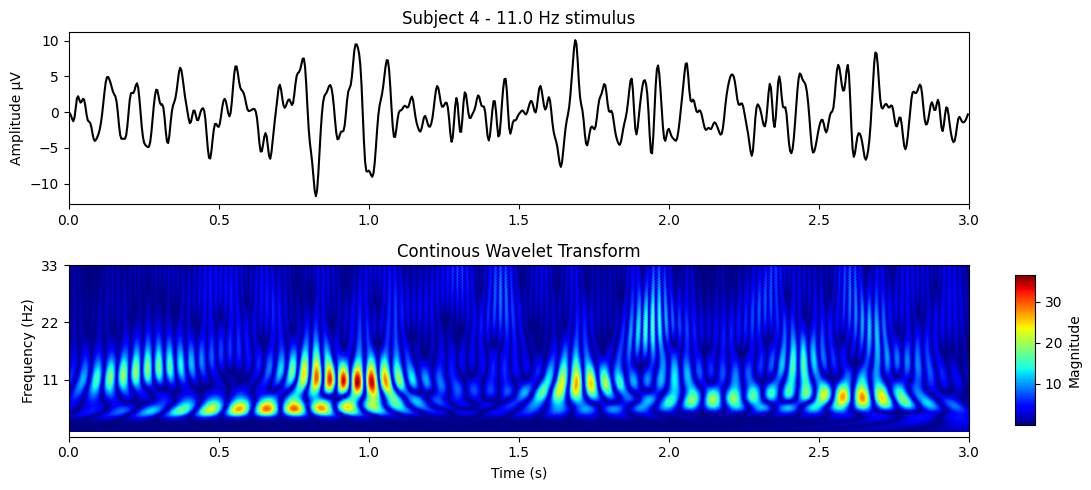

In [385]:
subject = 4
freq_index = 12

eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)
t = np.arange(0, 750/sampling_rate, 1/sampling_rate)

sampling_rate = 250

filtered_data = signal.lfilter(b, a, eeg_data[61, :, 0, freq_index])

frequencies = np.arange(1, 40, 0.01) /sampling_rate 
wavelet_name = "morl"
# Pasamos de frecuencias a escalas para utilizarlas en la transformada
scales = pywt.frequency2scale(wavelet_name, frequencies) 
# Transformada Wavelet
cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name) 
# Multiplicamos por samping_rate para recuperar las frecuencias en Hz
frequencies = frequencies*sampling_rate 

f_idx = freq_index
f_value = data_frequencies[f_idx]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 5))

ax1.plot(t,filtered_data, 'k')
ax1.set_xlim(0, 3)
ax1.set_ylabel("Amplitude " + '\u03BC' + "V")
ax1.set_title("Subject " + str(subject) + " - " + str(data_frequencies[freq_index]) +" Hz stimulus")

ax2.imshow(np.abs(cwtmatr), aspect='auto', cmap='jet', extent=[0, len(t) / sampling_rate, frequencies[-1], frequencies[0]], origin='upper')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title("Continous Wavelet Transform")
ax2.set_ylim(0, 30)
ax2.set_yticks([11, 22, 33])
cbar_ax2 = fig.add_axes([1.02, 0.14 , 0.02, 0.3])
plt.colorbar(ax2.images[0], cax=cbar_ax2, label="Magnitude")


plt.tight_layout()

# DATOS SUELTOS

In [134]:
subject = 18
frequency = 11

data_frequencies[35] = 15.6

fr_idx = 0
freq = frequency
for x in range(40):
    if data_frequencies[x] == freq:
        fr_idx = x
        break  



eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)

for tr_index in range(0, 4):

    filtered_data = signal.lfilter(b, a, eeg_data[61, :, tr_index, fr_idx])

    freqs = np.arange(1, 40, 0.01) /sampling_rate 
    wavelet_name = "morl"
    # Pasamos de frecuencias a escalas para utilizarlas en la transformada
    scales = pywt.frequency2scale(wavelet_name, freqs) 
    # Transformada Wavelet
    cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name)

    # Filter out magnitudes below 20
    cwtmatr_filtered = np.where(cwtmatr < 25, 0, cwtmatr)
    # Find the index of the maximum magnitude along the frequency axis for each time step
    max_freq_indices = np.argmax(cwtmatr_filtered, axis=0)
    # Extract the corresponding frequencies for each time step
    frequencies = np.arange(1, 40, step=0.01)
    max_freq_values = frequencies[max_freq_indices]

    result = 0
    total = 0

    result_2 = 0
    total_2 = 0

    for i in range(int(1*250), int(len(max_freq_values) - (0.5*250))):
        if max_freq_values[i] != 1:
            if np.abs(frequency - max_freq_values[i]) < 5 :
                result += np.abs(frequency - max_freq_values[i])
                total += 1
            total_2 += 1
            result_2 +=  np.abs(frequency - max_freq_values[i])
        

    print("Trial ", tr_index + 1, " average thickness = ", result_2/total_2, "  filtered = ", result/total)


Trial  1  average thickness =  1.3848412698412682   filtered =  0.5487499999999987
Trial  2  average thickness =  0.59020408163265   filtered =  0.59020408163265
Trial  3  average thickness =  0.7833766233766247   filtered =  0.4249315068493159
Trial  4  average thickness =  0.6006557377049161   filtered =  0.6006557377049161


In [71]:
#Medias para todos los sujetos (confirmando valore previos y añadiendo el filtrado)

In [124]:
table = np.zeros((70, 2))

for s in range(70):

    subject = s+1
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)

    for fr_idx in range(40):

        frequency = data_frequencies[fr_idx]

        for tr_index in range(0, 4):

            filtered_data = signal.lfilter(b, a, eeg_data[61, :, tr_index, fr_idx])

            freqs = np.arange(1, 40, 0.01) /sampling_rate 
            wavelet_name = "morl"
            # Pasamos de frecuencias a escalas para utilizarlas en la transformada
            scales = pywt.frequency2scale(wavelet_name, freqs) 
            # Transformada Wavelet
            cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name)

            # Filter out magnitudes below 20
            cwtmatr_filtered = np.where(cwtmatr < 25, 0, cwtmatr)
            # Find the index of the maximum magnitude along the frequency axis for each time step
            max_freq_indices = np.argmax(cwtmatr_filtered, axis=0)
            # Extract the corresponding frequencies for each time step
            frequencies = np.arange(1, 40, step=0.01)
            max_freq_values = frequencies[max_freq_indices]

            result = 0
            total = 0

            result_2 = 0
            total_2 = 0

            for i in range(int(0.5*250), int(len(max_freq_values) - (0.5*250))):
                if max_freq_values[i] != 1:
                    if np.abs(frequency - max_freq_values[i]) < 5 :
                        result += np.abs(frequency - max_freq_values[i])
                        total += 1
                    total_2 += 1
                    result_2 +=  np.abs(frequency - max_freq_values[i])
                        
            if total_2 != 0:
                table[s, 0] += result_2/total_2
            if total != 0:
                table[s, 1] += result/total

    table[s, 0] = table[s, 0]/160
    table[s, 1] = table[s, 1]/160

In [125]:

def color_final(val):
    if val < 0:
        return 'color: red'
    
df = pd.DataFrame(table)
styled_df = df.style.applymap(color_final)
display(styled_df)

/var/folders/v_/yyjjwqx93jj6f359gjx0mwsh0000gn/T/ipykernel_73938/2865953125.py:6: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(color_final)


,0,1
0,4.761030,1.537212
1,3.738935,1.951854
2,2.793812,1.161513
3,3.476389,1.667127
4,3.196791,2.188941
5,3.718367,1.350121
6,3.719670,2.323249
7,2.141263,1.501787
8,1.631731,0.773840
9,3.710840,1.570613


In [148]:
table = np.zeros((2, 16, 2))

subjects = [18, 64]
my_frequencies = [11, 13, 8.6, 15.6]


data_frequencies[35] = 15.6


for s in range(2):
    subject = subjects[s]
    eeg_data, eeg_data_stimulus_only, trial_length = utils.load_ssvep_data("../TFM-GitHub/Dataset BETA/",subject)

    for f in range(4):

        frequency = my_frequencies[f]

        fr_idx = 0
        freq = frequency
        for x in range(40):
            if data_frequencies[x] == freq:
                fr_idx = x
                break  

        for tr_index in range(0, 4):

            filtered_data = signal.lfilter(b, a, eeg_data[61, :, tr_index, fr_idx])

            freqs = np.arange(1, 40, 0.01) /sampling_rate 
            wavelet_name = "morl"
            # Pasamos de frecuencias a escalas para utilizarlas en la transformada
            scales = pywt.frequency2scale(wavelet_name, freqs) 
            # Transformada Wavelet
            cwtmatr, freqs = pywt.cwt(filtered_data, scales, wavelet_name)

            # Filter out magnitudes below 20
            cwtmatr_filtered = np.where(cwtmatr < 25, 0, cwtmatr)
            # Find the index of the maximum magnitude along the frequency axis for each time step
            max_freq_indices = np.argmax(cwtmatr_filtered, axis=0)
            # Extract the corresponding frequencies for each time step
            frequencies = np.arange(1, 40, step=0.01)
            max_freq_values = frequencies[max_freq_indices]

            result = 0
            total = 0

            result_2 = 0
            total_2 = 0

            for i in range(int(0.5*250), int(len(max_freq_values) - (0.5*250))):
                if max_freq_values[i] != 1:
                    if np.abs(frequency - max_freq_values[i]) < 5 :
                        result += np.abs(frequency - max_freq_values[i])
                        total += 1
                    total_2 += 1
                    result_2 +=  np.abs(frequency - max_freq_values[i])
                
            if total_2 != 0:
                table[s, f*4 + tr_index, 0] = result_2/total_2
            if total != 0:
                table[s, f*4 + tr_index, 1] = result/total


In [149]:
df = pd.DataFrame(table[0])
display(df)

,0,1
0,1.303669,0.545214
1,0.632932,0.632932
2,0.803185,0.453020
3,0.610979,0.610979
4,2.057368,1.004895
5,0.483737,0.483737
6,0.489924,0.489924
7,0.846733,0.846733
8,1.936149,0.797817
9,0.795629,0.430208


In [150]:
df = pd.DataFrame(table[1])
display(df)

,0,1
0,1.645500,1.381339
1,0.820571,0.820571
2,0.720588,0.720588
3,0.707969,0.707969
4,2.984207,1.863158
5,3.657961,1.352656
6,1.620685,1.265294
7,4.196138,2.286867
8,2.129126,2.129126
9,2.041272,2.041272
